# 1. Introduction :
<div style="text-align: justify">For this laboratory of Artificial Intelligence, we are going to train a model in order to be able to predict if a transaction is fraudulent or not based on the Xente Fraud Challenge. We will the data from Xente and the different concepts we studied during the course and laboratories such as Machine Learning, Feature Engineering.</div> 


# 2. Import Libraries :
<div style="text-align: justify">First, we need to import all the libraries we are going to use during this project.</div>

In [325]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker
from imblearn.over_sampling import SMOTE
from IPython.display import Image, display
import xgboost as xgb
from xgboost import XGBClassifier

# 3. Data loading :
<div style="text-align: justify"> Now we need to load the data we get from Xente. This data gives us many transactions with some information such as the time of the transaction or the account ID from which this transaction comes. It also gives us a Fraud Result, which is very important, because it is what we will use later on to train the model in order to predict if the transactions are fraudulent or not. We are calling this data the training_data, and we do a .describe in order to get a summary of the attributes of the column. </div> 


In [326]:
training_data = pd.read_csv("data/training.csv")
training_data.describe()

,CountryCode,Amount,Value,PricingStrategy,FraudResult
count,95662.0,9.566200e+04,9.566200e+04,95662.000000,95662.000000
mean,256.0,6.717846e+03,9.900584e+03,2.255974,0.002018
std,0.0,1.233068e+05,1.231221e+05,0.732924,0.044872
min,256.0,-1.000000e+06,2.000000e+00,0.000000,0.000000
25%,256.0,-5.000000e+01,2.750000e+02,2.000000,0.000000
50%,256.0,1.000000e+03,1.000000e+03,2.000000,0.000000
75%,256.0,2.800000e+03,5.000000e+03,2.000000,0.000000
max,256.0,9.880000e+06,9.880000e+06,4.000000,1.000000


## 3.1 Checking Data: 
<div style="text-align: justify">
As this is going to be our training data, it is really important to check if our data is balanced or imbalanced before using it. An imbalanced data set is the one that has biased class proportions, in other words, which has classes that are much more important than others. <br>
In our case, as we can see in the image <i>' Imbalanced data '</i>, we have significantly more non-fraudulent transactions than fraudulent ones. We have 193 fraudulent transactions, compared to the 95469 non-fraudulent ones, so our data is extremely imbalanced.<br>
 This is a problem because, with some few fraudulent data, the training model is going to spend most of its time on non-fraudulent transactions and will not learn enough from fraudulent transactions. In order to handle this, we will apply, further on, an up weighting technique called Smote, which will add to the dataset synthetically generated fraudulent transactions.
</div> 
  

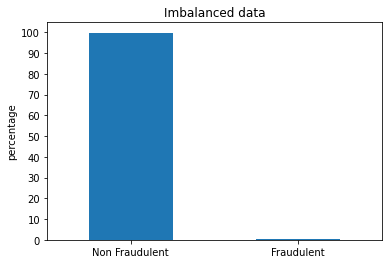

number of fraudulent transcactions in the training_data:  193
number of non fraudulent transcactions in the training_data:  95469


In [327]:
value = training_data['FraudResult'].value_counts()
proprtions = value / len(training_data) * 100
axe = proprtions.plot (kind = 'bar')
axe.yaxis.set_major_locator(ticker.MultipleLocator(10))
axe.set_ylabel('percentage')
custom_labels = ['Non Fraudulent', 'Fraudulent']
axe.set_xticklabels(custom_labels, rotation=0, ha='center')
axe.set_title('Imbalanced data')
plt.show()
ones = (training_data['FraudResult'] == 1).sum()
zero = (training_data['FraudResult'] == 0).sum()
print("number of fraudulent transcactions in the training_data: ",ones)
print("number of non fraudulent transcactions in the training_data: ", zero)

# 4. Cleaning data: 
## 4.1 Ids:
<div style="text-align: justify"> First we need to clean all the ID columns because the elements of these columns come with the ID number and also the name of the column, for example, <i>TransactionId_76871</i>. In order to use the Ids to train our model, we only need the numbers, so we deleted the strings from these columns.</div> 
 

In [328]:
# columns with Ids
id_cols = ['TransactionId', 'SubscriptionId', 'BatchId', 'AccountId','CustomerId','ProductId','ProviderId','ChannelId']
# remove the strings that are before the underscore in id_cols
for col in id_cols:
    training_data[col] = training_data[col].apply(lambda x : x.split("_")[-1])

training_data.head()


,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult
0,76871,36123,3957,887,4406,UGX,256,6,10,airtime,3,1000.0,1000,2018-11-15T02:18:49Z,2,0
1,73770,15642,4841,3829,4406,UGX,256,4,6,financial_services,2,-20.0,20,2018-11-15T02:19:08Z,2,0
2,26203,53941,4229,222,4683,UGX,256,6,1,airtime,3,500.0,500,2018-11-15T02:44:21Z,2,0
3,380,102363,648,2185,988,UGX,256,1,21,utility_bill,3,20000.0,21800,2018-11-15T03:32:55Z,2,0
4,28195,38780,4841,3829,988,UGX,256,4,6,financial_services,2,-644.0,644,2018-11-15T03:34:21Z,2,0


In [329]:
# Count the number of distinct elements in the training_data columns:
training_data.nunique()
#training_data.dtypes

TransactionId           95662
BatchId                 94809
AccountId                3633
SubscriptionId           3627
CustomerId               3742
CurrencyCode                1
CountryCode                 1
ProviderId                  6
ProductId                  23
ProductCategory             9
ChannelId                   4
Amount                   1676
Value                    1517
TransactionStartTime    94556
PricingStrategy             4
FraudResult                 2
dtype: int64

## 4.2 Set Index and drop:
<div style="text-align: justify">The transaction ID is the unique transaction identifier on the platform, we choose to set the transaction as an Index in order to improve the data organization, we try to arrange data in a way to facilitate analysis. Setting the index helps to organize, manipulate and the alignment of data in machine learning. In our case, we chose transaction ID as index. <br>
The drop function is used to drop specified columns. Before dropping any column, we used the nunique method to count the number of distinct elements in each column. We notice that 'CurrencyCode' and 'CountryCode' have only one distinct value and these columns may not provide any irrelevant information to our model and can degrade its performance, so we decided to delete them from training_data.
</div> 

In [330]:
training_data.drop(['CurrencyCode','CountryCode'],axis = 1, inplace=True)
training_data.set_index('TransactionId')

,BatchId,AccountId,SubscriptionId,CustomerId,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult
TransactionId,,,,,,,,,,,,,
76871,36123,3957,887,4406,6,10,airtime,3,1000.0,1000,2018-11-15T02:18:49Z,2,0
73770,15642,4841,3829,4406,4,6,financial_services,2,-20.0,20,2018-11-15T02:19:08Z,2,0
26203,53941,4229,222,4683,6,1,airtime,3,500.0,500,2018-11-15T02:44:21Z,2,0
380,102363,648,2185,988,1,21,utility_bill,3,20000.0,21800,2018-11-15T03:32:55Z,2,0
28195,38780,4841,3829,988,4,6,financial_services,2,-644.0,644,2018-11-15T03:34:21Z,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
89881,96668,4841,3829,3078,4,6,financial_services,2,-1000.0,1000,2019-02-13T09:54:09Z,2,0
91597,3503,3439,2643,3874,6,10,airtime,3,1000.0,1000,2019-02-13T09:54:25Z,2,0
82501,118602,4841,3829,3874,4,6,financial_services,2,-20.0,20,2019-02-13T09:54:35Z,2,0


## 4.3 Split TransactionStartTime:
<div style="text-align: justify">
In order to get more information of the transaction time column, we are splitting each value into 7 new columns where we are putting the year, month, day, hour, minute, second and day of the week in which the transaction took place. After that, we drop the <i> TransactionStartTime </i> column, as we don't need it anymore.
</div> 

In [331]:
training_data['year'] = pd.to_datetime(training_data['TransactionStartTime']).dt.year
training_data['month'] = pd.to_datetime(training_data['TransactionStartTime']).dt.month
training_data['day'] = pd.to_datetime(training_data['TransactionStartTime']).dt.day
training_data['hour'] = pd.to_datetime(training_data['TransactionStartTime']).dt.hour
training_data['minute'] = pd.to_datetime(training_data['TransactionStartTime']).dt.minute
training_data['second'] = pd.to_datetime(training_data['TransactionStartTime']).dt.second
training_data['day_of_week'] = pd.to_datetime(training_data['TransactionStartTime']).dt.dayofweek


# drop TransactionStartTime
training_data.drop(["TransactionStartTime"] ,axis = 1, inplace=True)
training_data.head()


,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,PricingStrategy,FraudResult,year,month,day,hour,minute,second,day_of_week
0,76871,36123,3957,887,4406,6,10,airtime,3,1000.0,1000,2,0,2018,11,15,2,18,49,3
1,73770,15642,4841,3829,4406,4,6,financial_services,2,-20.0,20,2,0,2018,11,15,2,19,8,3
2,26203,53941,4229,222,4683,6,1,airtime,3,500.0,500,2,0,2018,11,15,2,44,21,3
3,380,102363,648,2185,988,1,21,utility_bill,3,20000.0,21800,2,0,2018,11,15,3,32,55,3
4,28195,38780,4841,3829,988,4,6,financial_services,2,-644.0,644,2,0,2018,11,15,3,34,21,3


In [332]:
# Count the number of distinct elements in the training_data columns:
training_data.nunique()

TransactionId      95662
BatchId            94809
AccountId           3633
SubscriptionId      3627
CustomerId          3742
ProviderId             6
ProductId             23
ProductCategory        9
ChannelId              4
Amount              1676
Value               1517
PricingStrategy        4
FraudResult            2
year                   2
month                  4
day                   31
hour                  24
minute                60
second                60
day_of_week            7
dtype: int64

## 4.4 Categorical values:
<div style="text-align: justify">
Another problem we have on our training data is that we have categorical variables in <i>ProductCategory</i>. In order to solve this, we are going to apply One-Hot Encoding. This means that we are going to create a new column for each of the categories in <i>ProductCategory</i> and we will indicate for each transaction if it belongs to this category or not with a 1 or a 0 in the new columns. As we use the One-Hot Encoding, we don't need anymore the <i>ProductCategory</i> column, so we can drop it.  
</div> 

In [333]:

OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(training_data["ProductCategory"].values.reshape(-1,1)))
data = pd.get_dummies(training_data['ProductCategory'], columns=['ProductCategory'])
OH_cols_train.rename(columns=lambda x: "ProductCategory_" + str(data.columns[x]), inplace=True)

# print(data.columns)
# One-hot encoding removed index; put it back
OH_cols_train.index = training_data.index

# Remove categorical columns (will replace with one-hot encoding)
num_train = training_data.drop("ProductCategory", axis=1)


# Add one-hot encoded columns to numerical features
OH_train = pd.concat([num_train, OH_cols_train], axis=1)

# Ensure all columns have string type
OH_train.columns = OH_train.columns.astype(str)

OH_train.head()

c:\Users\pedro\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,ProviderId,ProductId,ChannelId,Amount,Value,...,day_of_week,ProductCategory_airtime,ProductCategory_data_bundles,ProductCategory_financial_services,ProductCategory_movies,ProductCategory_other,ProductCategory_ticket,ProductCategory_transport,ProductCategory_tv,ProductCategory_utility_bill
0,76871,36123,3957,887,4406,6,10,3,1000.0,1000,...,3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,73770,15642,4841,3829,4406,4,6,2,-20.0,20,...,3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,26203,53941,4229,222,4683,6,1,3,500.0,500,...,3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,380,102363,648,2185,988,1,21,3,20000.0,21800,...,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,28195,38780,4841,3829,988,4,6,2,-644.0,644,...,3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


# 5. Feature Engineering:
## 5.1 Mutual Information:
<div style="text-align: justify">
Mutual information measures the relationship between two values, it measures the statistical dependence between two variables, i.e how much knowledge of a variable provides information about the other variable.

In this case, we measure the dependence between Fraud result and the other variables in order to identify which feature has the most important information to predict the target. Mutual information provides a quantitative measure between FraudResult and the other variables, it can help to visualize the impact of a feature on the prediction. 
</div>

In [334]:
OH_train.describe()
OH_train = OH_train.apply(pd.to_numeric,errors = "coerce")
X = OH_train.copy()

y = X.pop('FraudResult')

discrete_features = X.dtypes 
discrete_features

TransactionId                           int64
BatchId                                 int64
AccountId                               int64
SubscriptionId                          int64
CustomerId                              int64
ProviderId                              int64
ProductId                               int64
ChannelId                               int64
Amount                                float64
Value                                   int64
PricingStrategy                         int64
year                                    int64
month                                   int64
day                                     int64
hour                                    int64
minute                                  int64
second                                  int64
day_of_week                             int64
ProductCategory_airtime               float64
ProductCategory_data_bundles          float64
ProductCategory_financial_services    float64
ProductCategory_movies            

In [335]:
def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_classif(X, y, discrete_features="auto")
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores[::3]  

PricingStrategy                 0.016120
Value                           0.012820
AccountId                       0.010271
month                           0.007902
CustomerId                      0.007195
day                             0.001293
minute                          0.000239
ProductCategory_utility_bill    0.000067
ProductCategory_ticket          0.000000
Name: MI Scores, dtype: float64

Years:  2
Months:  4


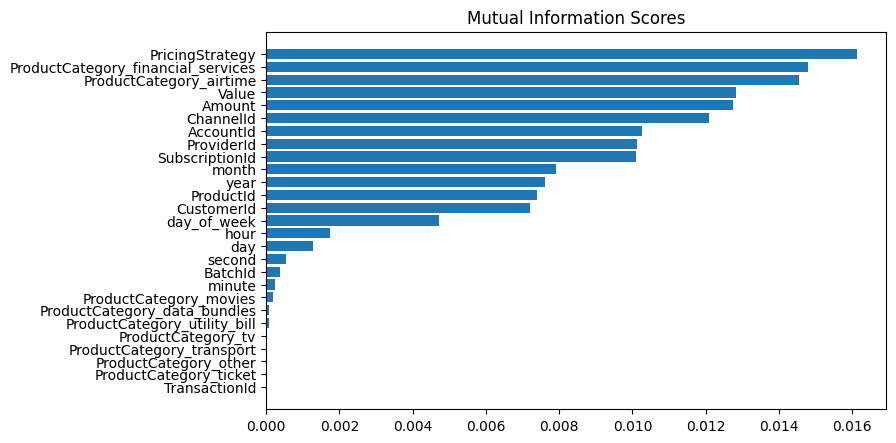

In [336]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

print('Years: ' ,OH_train.year.nunique())
print('Months: ' ,OH_train.month.nunique())

<div style="text-align: justify">
As we can see from the mutual information scores, the minutes and the seconds have a much smaller impact compared to the hours and the day of the week. For this reason, we decided to drop these two columns from our training dataset. <br>
Also, as we only have data from four months, we will not be able to train our model and predict the result of the transactions for the rest of the months of the year, so we decided to drop this column.<br>
Finally, the data comes from only two different years, which we believe that is not significantly enough to use this data in order to predict whether the transactions are going to be fraudulent based on the year.
</div> 

In [337]:
OH_train.drop(["minute","second", "year", "month"] ,axis = 1, inplace=True)
OH_train.head()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,ProviderId,ProductId,ChannelId,Amount,Value,...,day_of_week,ProductCategory_airtime,ProductCategory_data_bundles,ProductCategory_financial_services,ProductCategory_movies,ProductCategory_other,ProductCategory_ticket,ProductCategory_transport,ProductCategory_tv,ProductCategory_utility_bill
0,76871,36123,3957,887,4406,6,10,3,1000.0,1000,...,3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,73770,15642,4841,3829,4406,4,6,2,-20.0,20,...,3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,26203,53941,4229,222,4683,6,1,3,500.0,500,...,3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,380,102363,648,2185,988,1,21,3,20000.0,21800,...,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,28195,38780,4841,3829,988,4,6,2,-644.0,644,...,3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


<div style="text-align: justify">
In our data set, we had a column that contains different timestamps, which is the day column. To understand how the different parts of the day contribute to predict our target variable, we decided to split the day column into three different columns (morning, afternoon and night). Our objective was to analyze the impact of each part of the day to the target variable.
</div>

In [338]:
OH_train['morning'] = np.where((OH_train['hour'] >= 5) & (OH_train['hour'] < 13), 1, 0)
OH_train['night'] = np.where((OH_train['hour'] >= 21) | (OH_train['hour'] < 5), 1, 0)
OH_train['afternoon'] = np.where((OH_train['hour'] >= 13) & (OH_train['hour'] < 21), 1, 0)
#OH_train.loc[100:200, ['night','afternoon','morning', 'hour']]
#OH_train.loc[(OH_train.hour >= 23)]
OH_train.drop(["hour"] ,axis = 1, inplace=True)
OH_train.head()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,ProviderId,ProductId,ChannelId,Amount,Value,...,ProductCategory_financial_services,ProductCategory_movies,ProductCategory_other,ProductCategory_ticket,ProductCategory_transport,ProductCategory_tv,ProductCategory_utility_bill,morning,night,afternoon
0,76871,36123,3957,887,4406,6,10,3,1000.0,1000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0
1,73770,15642,4841,3829,4406,4,6,2,-20.0,20,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0
2,26203,53941,4229,222,4683,6,1,3,500.0,500,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0
3,380,102363,648,2185,988,1,21,3,20000.0,21800,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,1,0
4,28195,38780,4841,3829,988,4,6,2,-644.0,644,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0


<div style="text-align: justify">
We are now calculating the Mutual Information scores in order to see the impact of the new time columns we created. We can see that, most of the fraudulent transactions happen during the afternoon and the morning. This information is very useful, as we will be able to predict that if the transaction is made during the night, it is less likely going to be fraudulent than one made during the morning or afternoon.
</div>

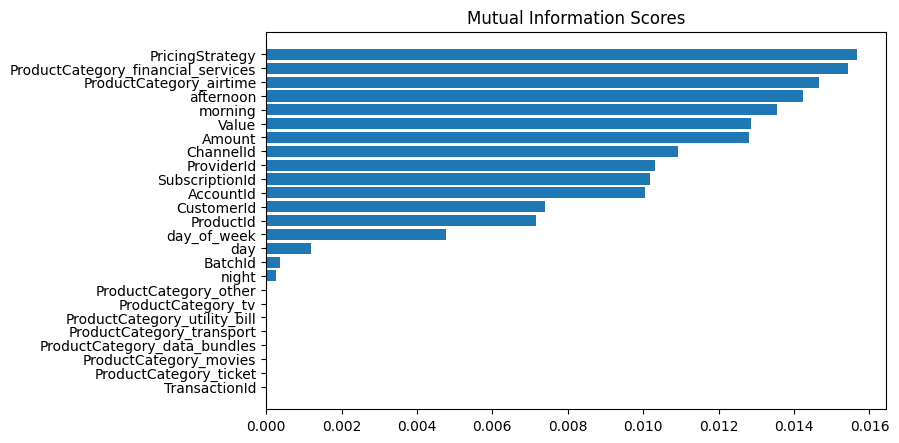

In [339]:
X = OH_train.copy()

y = X.pop('FraudResult')

discrete_features = X.dtypes 

mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores[::3]

plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

In [340]:
# Save the cleaned data in a new file in order to used it later to train our model
print(OH_train.head())
OH_train.to_csv('data/cleaned_data.csv', index=False)

   TransactionId  BatchId  AccountId  SubscriptionId  CustomerId  ProviderId  \
0          76871    36123       3957             887        4406           6   
1          73770    15642       4841            3829        4406           4   
2          26203    53941       4229             222        4683           6   
3            380   102363        648            2185         988           1   
4          28195    38780       4841            3829         988           4   

   ProductId  ChannelId   Amount  Value  ...  \
0         10          3   1000.0   1000  ...   
1          6          2    -20.0     20  ...   
2          1          3    500.0    500  ...   
3         21          3  20000.0  21800  ...   
4          6          2   -644.0    644  ...   

   ProductCategory_financial_services  ProductCategory_movies  \
0                                 0.0                     0.0   
1                                 1.0                     0.0   
2                                 0

# 6. Model:
## 6.1 Get data:
<div style="text-align: justify">
In this step, we are going to get the training data for our model, which is the data we cleaned previously and the test data that we get from Xente in order to check the performances of our model.
</div>

In [341]:
df = pd.read_csv('data/cleaned_data.csv')
test_data = pd.read_csv('data/test.csv')

test_data.set_index("TransactionId", inplace=True)

df.set_index("TransactionId", inplace=True)
test_data.drop(["CurrencyCode", "CountryCode"] ,axis = 1, inplace=True)
df.head()

,BatchId,AccountId,SubscriptionId,CustomerId,ProviderId,ProductId,ChannelId,Amount,Value,PricingStrategy,...,ProductCategory_financial_services,ProductCategory_movies,ProductCategory_other,ProductCategory_ticket,ProductCategory_transport,ProductCategory_tv,ProductCategory_utility_bill,morning,night,afternoon
TransactionId,,,,,,,,,,,,,,,,,,,,,
76871,36123,3957,887,4406,6,10,3,1000.0,1000,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0
73770,15642,4841,3829,4406,4,6,2,-20.0,20,2,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0
26203,53941,4229,222,4683,6,1,3,500.0,500,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0
380,102363,648,2185,988,1,21,3,20000.0,21800,2,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,1,0
28195,38780,4841,3829,988,4,6,2,-644.0,644,2,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0


## 6.2 Choosing features:
<div style="text-align: justify">
We have chosen our feature based on mutual information plots, which is an effective way to select relevant features for the model. We have chosen the feature based on their score in relation with the target variable. Features with higher score are more informative and helps more to predict the target variable. For example in our case we can see that <i>'PricingStrategy'</i> has the highest score compared to the other potential feature, it is very important to choose features with the highest score because they have strong connection with <i>'FraudResult'</i>.
</div>

In [342]:
# choosing Feautures
training_features = [
    'PricingStrategy', 
    'Value',
    'CustomerId',
    'ProviderId',
    'ProductId',
    'ChannelId',
    'AccountId', 
    'afternoon', 
    'morning', 
    'night', 
    'day_of_week', 
    'ProductCategory_airtime', 
    'ProductCategory_financial_services']

X = df[training_features]
y = df.FraudResult
X.head()

,PricingStrategy,Value,CustomerId,ProviderId,ProductId,ChannelId,AccountId,afternoon,morning,night,day_of_week,ProductCategory_airtime,ProductCategory_financial_services
TransactionId,,,,,,,,,,,,,
76871,2,1000,4406,6,10,3,3957,0,0,1,3,1.0,0.0
73770,2,20,4406,4,6,2,4841,0,0,1,3,0.0,1.0
26203,2,500,4683,6,1,3,4229,0,0,1,3,1.0,0.0
380,2,21800,988,1,21,3,648,0,0,1,3,0.0,0.0
28195,2,644,988,4,6,2,4841,0,0,1,3,0.0,1.0


## 6.3 Cleaning test data:
<div style="text-align: justify">
In order to test our model with the test dataset from Xente, we need to clean this dataset so that we have the same columns of the cleaned data. So we apply all the operations we did with the training data previously to <i>test_data</i>.
</div>

### 6.3.1 Clean Ids:

In [343]:

id_cols = ['SubscriptionId', 'BatchId', 'AccountId','CustomerId','ProductId','ProviderId','ChannelId']
for col in id_cols:
    test_data[col] = test_data[col].apply(lambda x : x.split("_")[-1])

### 6.3.2 Clean TransactionStartTime:
<div style="text-align: justify">
As we already decided that we are only going to use the day, hour and day of the week from the <i>TransactionStartTime</i> column, we don't need to get the other data. Once we get the needed data, we can drop the column.
</div>

In [344]:
test_data['day'] = pd.to_datetime(test_data['TransactionStartTime']).dt.day
test_data['hour'] = pd.to_datetime(test_data['TransactionStartTime']).dt.hour
test_data['day_of_week'] = pd.to_datetime(test_data['TransactionStartTime']).dt.dayofweek

# drop TransactionStartTime
test_data.drop(["TransactionStartTime"] ,axis = 1, inplace=True)


### 6.3.3 Categorical variables:
<div style="text-align: justify">
We are now going to apply the One-Hot Encoding to the <i> 'ProductCategory'</i> as we did for the training data and also separate the day into morning, afternoon and night based on the hours.
</div>

In [345]:
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_test = pd.DataFrame(OH_encoder.fit_transform(test_data["ProductCategory"].values.reshape(-1,1)))
data = pd.get_dummies(test_data['ProductCategory'], columns=['ProductCategory'])
OH_cols_test.rename(columns=lambda x: "ProductCategory_" + str(data.columns[x]), inplace=True)
# One-hot encoding removed index; put it back
OH_cols_test.index = test_data.index

# Remove categorical columns (will replace with one-hot encoding)
num_test = test_data.drop("ProductCategory", axis=1)


# Add one-hot encoded columns to numerical features
OH_test = pd.concat([num_test, OH_cols_test], axis=1)

# Ensure all columns have string type
OH_test.columns = OH_test.columns.astype(str)


OH_test.dtypes

OH_test['morning'] = np.where((OH_test['hour'] >= 5) & (OH_test['hour'] < 13), 1, 0)
OH_test['night'] = np.where((OH_test['hour'] >= 21) | (OH_test['hour'] < 5), 1, 0)
OH_test['afternoon'] = np.where((OH_test['hour'] >= 13) & (OH_test['hour'] < 21), 1, 0)
#OH_train.loc[100:200, ['night','afternoon','morning', 'hour']]
#OH_train.loc[(OH_train.hour >= 23)]
OH_test.drop(["hour"] ,axis = 1, inplace=True)

c:\Users\pedro\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


### 6.3.4 Training features:
<div style="text-align: justify">
We apply the same training features we used for the training data to the cleaned test data.
</div>

In [346]:
test = OH_test[training_features]

test.head()

,PricingStrategy,Value,CustomerId,ProviderId,ProductId,ChannelId,AccountId,afternoon,morning,night,day_of_week,ProductCategory_airtime,ProductCategory_financial_services
TransactionId,,,,,,,,,,,,,
TransactionId_50600,4,1000,2857,5,3,3,2441,0,1,0,2,1.0,0.0
TransactionId_95109,2,2000,3874,5,15,3,3439,0,1,0,2,0.0,1.0
TransactionId_47357,2,50,2857,4,6,2,4841,0,1,0,2,0.0,1.0
TransactionId_28185,4,3000,3105,5,10,3,2685,0,1,0,2,1.0,0.0
TransactionId_22140,2,60,3105,4,6,2,4841,0,1,0,2,0.0,1.0


## 6.4 Balancing data:
<div style="text-align: justify">
As we explained before, our dataset is imbalanced, so we need to balance it. In order to do that, we are going to use the function Smote that generates examples for the minority class. It creates new samples by interpolating between existing class samples. Smote helped our model to learn from a balanced dataset, which will improve the efficiency of the prediction.
</div>

In [347]:
X = df[training_features]
y = df.FraudResult
def balance_data(df, y):
    sm = SMOTE(random_state=42)
    X_resampled, y_resampled = sm.fit_resample(df, y)
    return X_resampled, y_resampled 

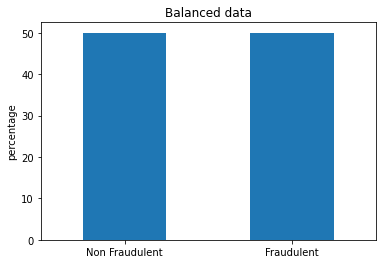

number of fraudulent transcactions in the training_data:  95469
number of non fraudulent transcactions in the training_data:  95469


In [348]:
X_resampled, y_resampled = balance_data(df,y)
X_resampled.head()
value = X_resampled['FraudResult'].value_counts()
proprtions = value / len(X_resampled) * 100
axe = proprtions.plot (kind = 'bar')
axe.yaxis.set_major_locator(ticker.MultipleLocator(10))
axe.set_ylabel('percentage')
custom_labels = ['Non Fraudulent', 'Fraudulent']
axe.set_xticklabels(custom_labels, rotation=0, ha='center')
axe.set_title('Balanced data')
plt.show()
ones = (X_resampled['FraudResult'] == 1).sum()
zero = (X_resampled['FraudResult'] == 0).sum()
print("number of fraudulent transcactions in the training_data: ",ones)
print("number of non fraudulent transcactions in the training_data: ", zero)

<div style="text-align: justify">
As we can see, the Smote function worked properly, and we have the same amount of fraudulent and non-fraudulent transactions. Now that the data set is balanced, we can start predicting with our model. We will start using a Decision Tree Classifier, and then we will use a Random Forest Regressor in order to compare the different results we obtain with each of these methods.
</div>

## 6.5 Decision Tree Classifier:
<div style="text-align: justify">
The Decision Tree Classifier is based in a tree structure where the leaves represent the class labels and the branches represent the features we chose that will lead to those class labels. The problem with these models is that if you take too many leaves, you can find a problem of overfitting and on the other hand, if you don't take enough leaves you will have a problem of underfitting. <br>
    <b> Overfitting :</b> This is when you have too many leaves, so that your model will match the training data almost perfectly, but when you use the validation data or new data it will act poorly. <br>
    <b> Underfitting :</b> This happens in the opposite case, when you don't have enough leaves in your model and will make that the predictions will be far off, even in the training data. <br>
    For this reason, and in other to avoid these two problems, it is important to choose correctly the maximum amount of leaves that you want your model to have. In the case of this project, we will start by only applying the Decision Tree without choosing a max_leaf_nodes and then create a function that will apply different max_leaf_nodes between 30 and 110 in order to compare the different results we obtain without this condition and with it and also be able to determine the amount of leaves that will make our model perform better.
    
</div>

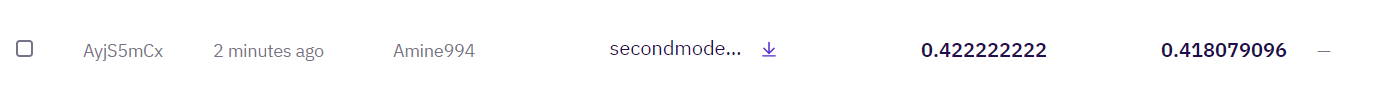

In [349]:
#Get the balanced data
X_resampled, y_resampled = balance_data(X,y)
#split the data into training data and validation data
train_X, val_X, train_y, val_y = train_test_split(X_resampled, y_resampled,random_state = 0)

#apply Decision Tree
training_tree_model = DecisionTreeClassifier(random_state = 1)
training_tree_model.fit(train_X, train_y)
train_decision_preds = training_tree_model.predict(test)

train_decision_preds.shape

# index_val = list(test.index.values.tolist())
# data = {'TransactionId': index_val,
#         'FraudResult': train_decision_preds}

# model_result = pd.DataFrame(data)
# model_result.shape
# model_result.to_csv('data/secondmodelresult.csv', index=False)

image_path = 'Images/DecisionTreeDefault.png'
display(Image(filename=image_path))

<div style="text-align: justify">
As we can see, when we use the Decision Tree Classifier with the default parameters and test our score directly on Xente, we obtain a 0.422222 public score and 0.418079 private score. We will now check what is the best tree depth for our model and compare the scores we obtain with the default score.
</div>

### 6.5.1 Max leaf nodes impact:
<div style="text-align: justify">
As explained before, we are now going to apply to the decision tree the different amount of leaves that we have in the <i> 'max_leaf_nodes_list' </i> in order to determine what is the best amount of leaves for our model.
</div>

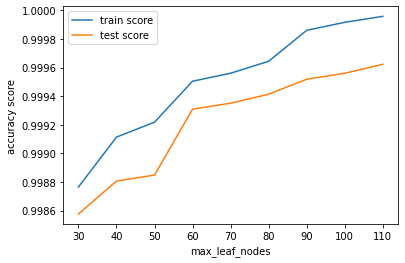

[0.99876399 0.99911315 0.99921789 0.9995042  0.99956007 0.99964386
 0.99986034 0.9999162  0.9999581 ]
[0.99857547 0.99880591 0.99884781 0.99930868 0.99935058 0.99941343
 0.99951817 0.99956007 0.99962292]


In [351]:

max_leaf_nodes_list = [30,40,50,60,70,80,90,100,110]
# X_resampled, y_resampled = balance_data(X,y)
train_X, val_X, train_y, val_y = train_test_split(X_resampled, y_resampled,random_state = 0)

train_score = np.zeros(len(max_leaf_nodes_list))
test_score = np.zeros(len(max_leaf_nodes_list))

#Apply different max_leaf_nodes to our model
for i, max_leaf_nodes in enumerate(max_leaf_nodes_list):
    tree = DecisionTreeClassifier(max_leaf_nodes = max_leaf_nodes, random_state = 1)
    tree.fit(train_X, train_y)
    train_score[i] = accuracy_score(train_y, tree.predict(train_X))
    test_score[i] = accuracy_score(val_y, tree.predict(val_X))

plt.plot(max_leaf_nodes_list, train_score, label="train score")
plt.plot(max_leaf_nodes_list, test_score, label="test score")

plt.legend()
plt.xlabel("max_leaf_nodes")
plt.ylabel("accuracy score")
plt.show()

print(train_score)
print(test_score)

<div style="text-align: justify">
After testing different depths for the Decision Tree, we can see that it's when we use a <i> 'max_leaf_nodes'</i> between 60 and 80 that our test score is closer to the train score. This means that, this is when our model suits best the reality. Before that, we can see that between 40 and 50, our test score is far off from the train score, this is because we don't have enough depth and we have an underfitting problem. <br>
On the other hand, we can see that over 80 the scores start to split appart again, this is due because the depth we are using is to elevated and we have an overfitting problem. <br>
Finally, we can see that over 100 the distance between the two scores is relatively constant, this means that the maximum nodes of our model is 100. The model doesn't go over that and we obtain the same results all the time when we try to use a <i> 'max_leaf_nodes' </i> higher than a 100.


</div>

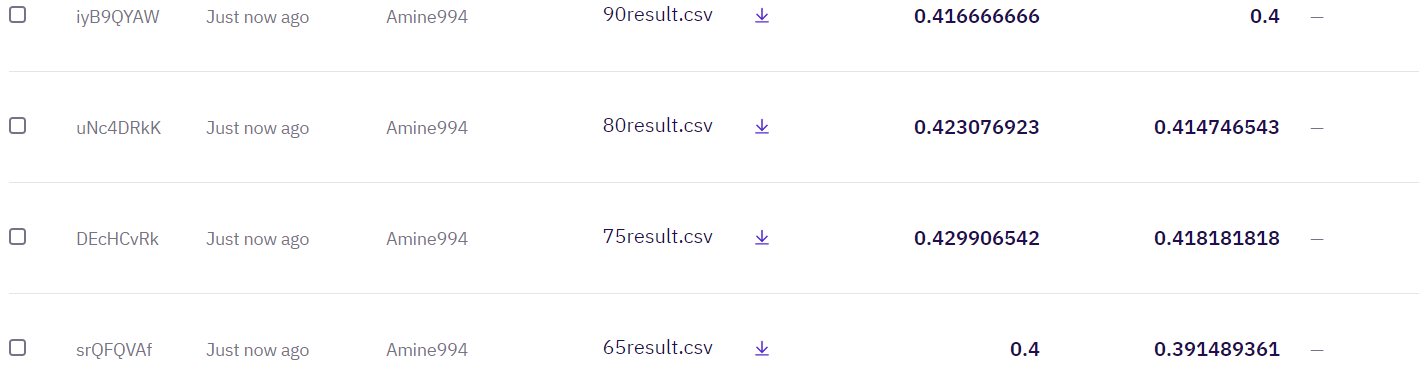

In [204]:
training_tree_model = DecisionTreeClassifier(max_leaf_nodes = 75, random_state = 1)
training_tree_model.fit(train_X, train_y)
train_decision_preds = training_tree_model.predict(test)

train_decision_preds.shape

index_val = list(test.index.values.tolist())
data = {'TransactionId': index_val,
        'FraudResult': train_decision_preds}


image_path = 'Images/DecisionTreeLeafNodes.png'
display(Image(filename=image_path))

model_result = pd.DataFrame(data)
model_result.shape
model_result.to_csv('data/75result.csv', index=False)

#on a un score de 0.422222 comme score public et 0.418 en score privee
#on utilisé max_leaf_nodes
# 3 - 0.134408602     0.142857142
# 30 - 0.381679389    0.392452830
  

<div style="text-align: justify">
    We trained our model with different values of leaf nodes. We trained it with four different values (65,75,80,90), we tested our score directly in Xente, we obtained:
    <ul>
    <li>0.4 as a public and 0.39 as private for 65 leaf nodes.</li>
    <li>0.429 as a public and 0.418 as private for 75 leaf nodes.</li>
    <li>0.423 as a public and 0.414 as private for 80 leaf nodes.</li>
    <li>0.416 as a public and 0.4 as private for 90 leaf nodes.</li>
    </ul>
    as we can see 75 leaf nodes gave us the best public and private score  in Xente. If we use more leaf nodes we will fall into overfitting and if we use less leaf nodes we will be in the underfitting
</div>

## 6.6 Random Forest Classifier:
<div style="text-align: justify">
    In order to avoid the underfitting and overfitting problems of the Decision Trees, we can use the Random Forest model. They use many trees and make predictions by averaging the predictions of each one of these trees. As it takes uses many trees, they usually have a much better predictive accuracy than a single Decision Tree and will work well using only the default parameters, compared to the Decision Tree, that with the default parameters we had a worse result than when applying <i>'max_leaf_nodes'</i>.<br>
    First, we will start by applying the Random Forest with default parameters and compare the results with the ones obtained previously using the Decision Tree. Then, we will play around with the Random Forest parameters, such as the <i> 'n_estimators'</i>, and compare the different results obtained. 
</div> 

### 6.6.1 Default parameters:

In [193]:
X_resampled, y_resampled = balance_data(X,y)
train_X, val_X, train_y, val_y = train_test_split(X_resampled, y_resampled,random_state = 0)
training_forest_model = RandomForestClassifier(random_state=1)
training_forest_model.fit(train_X, train_y)
train_preds = training_forest_model.predict(test)
score1 = training_forest_model.score(val_X, val_y)
# test.head()

# train_preds.shape

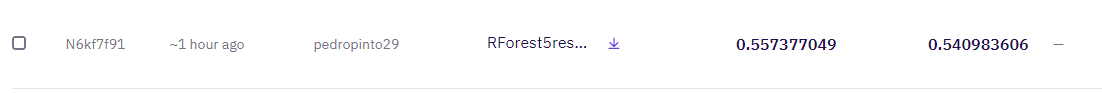

In [205]:
index_val = list(test.index.values.tolist())
data = {'TransactionId': index_val,
        'FraudResult': train_preds}
df = pd.DataFrame(data)

# df.to_csv('data/RForest5result.csv', index=False)
#on a un score de 0.55738 comme score public et 0.540983 en score privee 

image_path = 'Images/RandomForestDefault.png'
display(Image(filename=image_path))

<div style="text-align: justify">
As we can see, when we used Random Forest tree with default parameters we obtain a significantly higher score than the best score we obtained from the Decision Tree Classifier either with default parameters or what we consider the best depth for this model which is 75. This is due to the fact that the Random Forest uses, by default, 100 different Decision Trees and does an average of the scores obtained to give us a score.
</div>

### 6.6.2 N_estimators impact:

In [190]:
# # n_estimators_list = [50,100,150,200,250]
# X_resampled, y_resampled = balance_data(X,y)
# train_X, val_X, train_y, val_y = train_test_split(X_resampled, y_resampled,random_state = 0)
# forest_model = RandomForestClassifier(n_estimators=200, random_state=1)
# forest_model.fit(train_X, train_y)
# train_preds = training_forest_model.predict(test)

# train_preds.shape


(45019,)

In [194]:
# score2 = forest_model.score(val_X, val_y)
# print(score1)
# print(score2)

# # index_val = list(test.index.values.tolist())
# # data = {'TransactionId': index_val,
# #         'FraudResult': train_preds}

# # df = pd.DataFrame(data)

# # df.to_csv('data/RForest2000Result.csv', index=False)

0.9996857651618309
0.9991620404315492


## 6.7 XGBoost: 

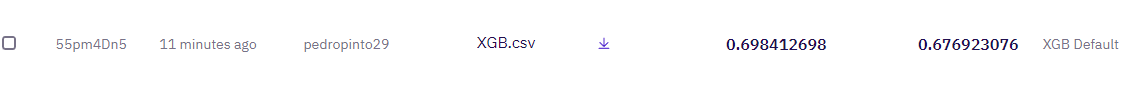

In [225]:
test = test.apply(pd.to_numeric,errors = "coerce")

X_resampled, y_resampled = balance_data(X,y)
train_X, val_X, train_y, val_y = train_test_split(X_resampled, y_resampled, test_size= 0.2,random_state = 42)

xgb_model = XGBClassifier()
xgb_model.fit(train_X, train_y)
y_pred = xgb_model.predict(test)

# accuracy = accuracy_score(val_y, y_pred)
# print("Accuracy:", accuracy)

index_val = list(test.index.values.tolist())
data = {'TransactionId': index_val,
        'FraudResult': y_pred}
df = pd.DataFrame(data)

df.to_csv('data/XGB.csv', index=False)

image_path = 'Images/XGBDefault.png'
display(Image(filename=image_path))